In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
from smodels.experiment.databaseObj import Database
from smodels.share.models import SMparticles, mssm
from smodels.tools.physicsUnits import fb, TeV, pb, GeV
from smodels.tools import runtime
from smodels.theory.element import Element
from smodels.tools.simplifiedLikelihoods import Data, UpperLimitComputer
import matplotlib.pyplot as plt
import seaborn as sns
runtime._drmax = 0.338
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("deep"))

### Load database

In [2]:
db = Database('../official124_smodels200.pcl')

### Get efficiency maps for all SRs and UL map

In [3]:
#Get EM:
expEM = db.getExpResults(analysisIDs=['ATLAS-SUSY-2016-07'],dataTypes=['efficiencyMap'],txnames=['T2'])[0]
expUL = db.getExpResults(analysisIDs=['ATLAS-SUSY-2016-07'],dataTypes=['upperLimit'],txnames=['T2'])[0]

#### Get points in UL map

In [4]:
#Get the UL data:
dataUL = eval(expUL.datasets[0].txnameList[0].txnameData.origdata,
               {'fb' : fb, 'pb' : pb, 'GeV' : GeV, 'TeV' : TeV})


#### Get efficiencies for all grid points in the UL map

In [5]:
#Get the efficiencies for each point for all datasets and the corresponding
#upper limits from the UL map
effs = []
xsecULsOrig = []
for pt in dataUL:
    mass = pt[0]
    effDict = {}
    for ds in expEM.datasets:
        eff = ds.txnameList[0].txnameData.getValueFor(mass)
        effDict[ds.dataInfo.dataId] = eff
    if all([(eff == None or eff == 0.0) for eff in effDict.values()]):
        continue
    mass = mass[0]
    mass = [m.asNumber(GeV) for m in mass]
    xsecULsOrig.append(mass+[pt[1].asNumber(fb)])
    effs.append([mass,effDict])
    
xsecULsOrig = np.array(xsecULsOrig)    

#### Compute upper limit  and expected upper limit for each SR

In [6]:
ulDict = {}
ulExpDict = {}
lumi = 36.1/fb
ntoys, alpha = 200000, .05
comp = UpperLimitComputer(ntoys, 1. - alpha)
for ds in expEM.datasets:
    Nbg = ds.dataInfo.expectedBG
    bgErr2 = ds.dataInfo.bgError**2
    Nobs = ds.dataInfo.observedN
    #Observed UL:
    dataModel = Data(Nobs, Nbg, bgErr2, None, 1. )
    ul = comp.ulSigma(dataModel, marginalize=False )/lumi.asNumber(1./fb)
    #Expected UL:
    dataModel = Data(Nbg, Nbg, bgErr2, None, 1. )
    ulExp = comp.ulSigma(dataModel, marginalize=False )/lumi.asNumber(1./fb)
    ulDict[ds.dataInfo.dataId] = ul
    ulExpDict[ds.dataInfo.dataId] = ulExp

#### Compute production cross-section UL using best expected SR

In [7]:
xsecULs = []
for pt in effs:
    mass = pt[0]
    effDict = pt[1]
    uls = dict([[SR,ulDict[SR]/eff] for SR,eff in effDict.items() if eff])
    ulsExp = [[SR,ulExpDict[SR]/eff] for SR,eff in effDict.items() if eff]
    #Use the best expected SR to set the limit:
    bestSR = ulsExp[np.argmin([x[1] for x in ulsExp])][0]
    ul = uls[bestSR]
    ulExp = dict(ulsExp)[bestSR]
    xsecULs.append(mass+[ul,ulExp])
xsecULS = np.array(xsecULs)

### Plot comparison: upper limits from EM vs upper limits from UL map)
#### Obs: some SRs (RJR) included in the UL map were not included as datases

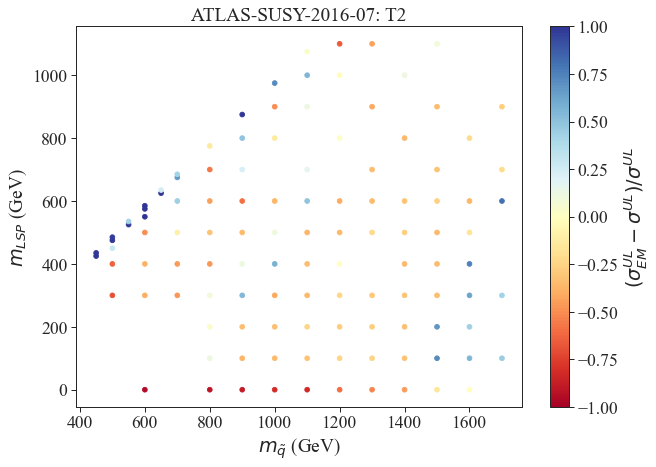

In [8]:
fig = plt.figure(figsize=(10,7))
plt.scatter(xsecULsOrig[:,0],xsecULsOrig[:,1],c=(xsecULS[:,2]-xsecULsOrig[:,2])/xsecULsOrig[:,2],
            cmap=plt.cm.get_cmap('RdYlBu'),  vmin=-1.,vmax=1.0)
plt.xlabel(r'$m_{\tilde q}$ (GeV)')
plt.ylabel(r'$m_{LSP}$ (GeV)')
plt.colorbar(label=r'$(\sigma^{UL}_{EM} - \sigma^{UL})/\sigma^{UL}$')
plt.title('ATLAS-SUSY-2016-07: T2')
plt.show() #If the computation is fully consistent we expect all points to be close to zero